<a href="https://colab.research.google.com/github/alexv710/debias_cv_data/blob/main/Bias_AI_Assisted_CV_Screening.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this colab we will explore the bias  in AI-assisted CV screening that could lead to illigal discrimination and experiment with different techniques to mitigate it. 

We will be using "Unintended Effects of Anonymous Résumés" dataset by [(Behaghel et al., 2015)](https://www.aeaweb.org/articles?id=10.1257/app.20140185).


Notes: 
* We will be focusing only on gender as a proof of concept. However, these techniques for both identifying the bias and mitigating it could be applied to other protected groups. 
* In this dataset, gender is represented as a binary variable, where female is set to 1 and male is set to 0. 

## Imports

In [48]:
import io
import random

import pandas as pd

import numpy as np

# plots and visualizations
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau

# To ignore future version warnings for seaborn distplot.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Fixing the seed in all libraries for reproducible results
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

# Data Preprocessing

In [49]:
# apply the min-max scaling in Pandas using the .min() and .max() methods
def min_max_scaling(df):
    # copy the dataframe
    df_norm = df.copy()
    # apply min-max scaling
    for column in df_norm.columns:
        df_norm[column] = (df_norm[column] - df_norm[column].min()) / (df_norm[column].max() - df_norm[column].min())
        
    return df_norm

# read the mainsample.dta file for further processing 

data = pd.io.stata.read_stata("data_candidates_mainsample.dta")
data.to_csv('data_candidates_mainsample.csv')

# Import the mainsample via StataReader to use variable_labels (old version of the read_stata)

data_stata = pd.io.stata.StataReader("data_candidates_mainsample.dta")
data_labels = data_stata.variable_labels()

# Remove all columns in the dataset for which no labels exist
# Those are mostly columns needed for p-tests and some matrix calculations in
# Stata. The outputted labels are those that are kept in the data

data = data.drop(columns=['CVAxORIGINE_IM_12', 'CVAxZUS_CUCS', 'CVAxZetI', 'C', 'CVA0',\
                          'p_offre1', 'control_manquant', 'ZouI_pred', 'ZouI0', 'ALE_16'])

# Remove sampling weights (within and out of the experiment)

data = data.drop(columns='POIDS_SEL')

# Remove all the centered features

data = data.drop(columns=['FEMME_c', 'a30m_c', 'a3049_c', 'a50p_c', 'dip_aucun_c',\
                          'dip_bepcap_c', 'dip_bac_c', 'dip_bac2p_c', 'recherche_LD_c', 'recherche_TLD_c'])

# Remove all features that are not directly derivable from the CVs or that have missing data

data = data.drop(columns=['RECRUTE', 'REFUSAL', 'codage_cv', 'ORIGINE_IM_1', 'ORIGINE_IM_2',\
                          'ORIGINE_IM_12', 'ID_OFFRE', 'ID_CANDIDAT', 'travail_etranger', 'duree_expro_offre'])

# Remove additional features that seem to bring no value or are unclear in the methodology according to the original paper

data = data.drop(columns=['CV_hesit_', 'CV_hesit', 'CV_note_7p', 'ZetI', 'permis', 'CV_attrayant_'])

# Remove CV coding feature: CV_qualif -> adequate skills 

#data = data.drop(columns=['CV_qualif'])

for key, value in data_labels.items():
    for col in data.columns:
        if key==col:
            # print(key, ':    ', value)
            if len(value)==0 or value.startswith('ID_OFFRE==') or value.startswith('Dummy for local job center'):
                data = data.drop(columns=col)

data['CV_qualif_sup'] = data['CV_qualif_sup'].fillna(0)
data['CV_qualif_inf'] = data['CV_qualif_inf'].fillna(0)
data['PREN_MUSULMAN'] = data['PREN_MUSULMAN'].fillna(0)
data['ZUS_CUCS'] = data['ZUS_CUCS'].fillna(0)
data['recherche_TLD'] = data['recherche_TLD'].fillna(0)

data['etudes_etranger'] = data['etudes_etranger'].fillna(0)
data['langue_anglais'] = data['langue_anglais'].fillna(0)
data['langue_arabe'] = data['langue_arabe'].fillna(0)
data['langue_autres'] = data['langue_autres'].fillna(0)
data['CV_formation_'] = data['CV_formation_'].fillna(0)

# derived from CV_experience_3p

data['CV_experience_'] = data['CV_experience_'].fillna(0.5)

# fill with 1 since missing records are not in the other age groups

data['a26m'] = data['a26m'].fillna(1)

# Assign medium grade for all unknown records
data['CV_note_2'] = data['CV_note_2'].fillna(0)
data['CV_note_3'] = data['CV_note_3'].fillna(1)
data['CV_note_4'] = data['CV_note_4'].fillna(0)
data['CV_note_5'] = data['CV_note_5'].fillna(0)

for item in data:
    if data[item].isna().sum() > 0:
        print(item, data[item].isna().sum())
        
# Normalize remaining columns to values between 0 and 1
# call the min_max_scaling function

data = min_max_scaling(data)

# Create a dataframe for the anonymized and not anonymized data

X = pd.DataFrame()

# Upsampling the interviewed entries

for index, row in data.iterrows():
    if row['ENTRETIEN'] == 1:
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        data = data.append(row)
        
# Assign the interviewed column to our target vector

y = data['ENTRETIEN']

# Drop the Interviewed/hired & anonymized columns (hired is much dependend on the number of jobs available
# and will currently not be considered as target label)

X = data.drop(columns=['CVA', 'ENTRETIEN'])

CVA 203


### Data Preparation for models

In [50]:
# Train, Test split
# Fixed random seed for debugging to avoid random splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=1)
X_train.head()

,PREN_MUSULMAN,ZUS_CUCS,ZouI,FEMME,a50p,a3049,a26m,dip_aucun,dip_bepcap,dip_bac,dip_bac2p,dip_bac2,dip_bac3p,recherche_LD,recherche_TLD,SALREV_SMIC_2,etudes_etranger,langue_anglais,langue_arabe,langue_autres,CV_inactivite,CV_qualif,CV_experience_3p,CV_note_2,CV_note_3,CV_note_4,CV_note_5,CV_qualif_sup,CV_qualif_inf,CV_experience_,CV_formation_,effent_200plus,service_nm,service_m,industrie,construction,cadre,profint,eoq,CDI,CNT_sup6m,poste_unique
992,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.428571,0.25,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1165,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.000000,0.50,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
1426,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.329512,0.545255,0.582851,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
102,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.428571,0.50,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
572,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,1.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.714286,0.50,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0


## Neural Network

The neural network is built using Keras with one input layer with the activation function relu and one output layer using a sigmoid activation function for binary classification. In addition two hidden layers are added, all with relu activation function.

In [51]:
# define and train keras NN model, returns a trained model
def build_train_model(X, y):
 
  # re-fixing the seed in all libraries for reproducible results
  random.seed(1)
  np.random.seed(1)
  tf.random.set_seed(1)

  # define model
  model = keras.Sequential(
      [
          # input layer
          layers.Dense(56, input_dim=X_train.shape[1], activation='relu'),

          # hidden layers  
          layers.Dense(24, activation='relu'),
          layers.Dense(12, activation='relu'),
          
          # output layer
          layers.Dense(1, activation='sigmoid')
      
      ]
  )

  # compile model
  model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["mse", 'accuracy'])

  # Learning Rate Annealer
  lrr = ReduceLROnPlateau(monitor='val_loss',
                        factor=.01,
                        patience=4,
                        min_lr=1e-8,
                        verbose=0)
  # Early stopping
  es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",\
                                        patience=8, verbose=1, mode="auto", baseline=None, restore_best_weights=True)

  # fit model
  model.fit(np.array(X), np.array(y), epochs=100, callbacks=[es, lrr], validation_split=0.2, shuffle=True, verbose=0)

  # return trained model
  return model

In [52]:
 # Evaluate the model performance, takes a trained model and test-set
 def evaluate_model(model, X_test,y_test):
  # print model accuracy on test-set
  _, _, accuracy = model.evaluate(X_test, y_test,verbose=0)
  print('Accuracy on test-set: %.2f%%' % (accuracy*100))
  # making a prediction on test data
  y_test_pred = model.predict(X_test)
  # converting the sigmoid output to binary class
  y_test_pred = [1 if y_test_pred[i]>0.5  else 0 for i in range(len(y_test_pred))]
  # print confusion matrix
  print('Confusion matrix:\n',confusion_matrix(y_test, y_test_pred))

In [53]:
model = build_train_model(X_train,y_train)
#model.summary()
evaluate_model(model, X_test,y_test)

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Accuracy on test-set: 96.48%
Confusion matrix:
 [[128   8]
 [  1 119]]


# Investigating bias in models predictions

In this section we will focus on exploring gender bias.

## Methodology:
1. Create a modified test-set, where we have two copies of each example once as male and another as female.

2. Testing the model with the modified test-set

3. Plotting the results with the modified test-set \\
  3.1. Plot a histogram of hiring probability of each gender. \\
  3.2. Calculate difference in  probabilities between coresponding examples (same example with inverted gender). \\
  3.3. Plot density of this difference. \\
  
If gender markers is not considered in the model predictions, the density plot should be centered around 0 i.e. no difference. the bigger the difference away from 0, the more biased the model.



#### Plot and auxiliary functions

In [54]:
# Returns the probability of being interviewed for all test examples,
# when the gender field is set to female vs. male.
def get_gender_prob(model, X_test):
  # copying all applicants and changing the gender field to female
  fem_test = X_test.copy()
  fem_test = fem_test.assign(FEMME=1)

  # copying all applicants and changing the gender field to male
  m_test = X_test.copy()
  m_test = m_test.assign(FEMME=0)

  # sanity check
  #print(sum(m_test['FEMME']==1), m_test.shape,X_test.shape)

  # get predictions probability for the interviewed class, for both data-subsets
  fem_prob = model.predict(fem_test)
  m_prob = model.predict(m_test)
  return fem_prob, m_prob

In [55]:
# Plots histogram of probability of being interviewed for both genders.
def plot_hist_prob(fem_prob, m_prob):
  # Sub-setting the interviewed class probability for the histogram.
  plt.figure(figsize=(6,4))
  plt.hist(fem_prob[:,0], bins=10, alpha=0.5, facecolor='darkgoldenrod', label="Female")
  plt.hist(m_prob[:,0], bins=10, alpha=0.5, facecolor='royalblue', label="Male")


  plt.xlabel("Probability", size=14)
  plt.ylabel("Count", size=14)
  plt.title("Female applicants interview prob. vs. male applicants")
  plt.legend(loc='upper right')
  # plt.savefig("hiring_prob_initial_model.png")

In [56]:
# Computes the difference between interview probability for each sample when
# the gender field is set to female vs. male (0 means no difference, +ve means
# higher probability when the field was set to male, and vice versa).
# Plots density of this difference.
def plot_density_prob_diff(fem_prob, m_prob):
  # number of times where being a male increased the interview probability.
  diff = (m_prob[:,0]-fem_prob[:,0])
  x0 = -0.3
  x1 = 0.3

  #plotting the PDF (do this before plotting anything else)
  ax = sns.distplot(diff, hist=False,color='royalblue')
  kde_x, kde_y = ax.lines[0].get_data()

  #plotting the two lines
  p1 = plt.axvline(x=x0,color='darkgoldenrod')
  p2 = plt.axvline(x=x1,color='darkgoldenrod')


  ax.fill_between(kde_x, kde_y, where=(kde_x<x0) | (kde_x>x1) , 
                  interpolate=True, color='darkgoldenrod')


  ax.set_yticks(ticks=np.arange(0,2.5,0.1),minor=True)
  # Add the grid
  ax.grid(which='minor', axis='y', linestyle='-')
  ax.grid(which='major', axis='y', linestyle='-')
  ax.set_xlim(-1.5,1.5)
  ax.set_ylim(0,2.5)

  plt.xlabel("(male interview prob.) - (female interview prob.)", size=14)
  plt.ylabel("Density", size=14)
  plt.title("Density plot of difference in interview prob.")
  plt.text(-1, 0.4, ("Female > Male\n%d" % sum(diff < -0.3)),horizontalalignment='center')
  plt.text(1, 0.4, ("Male > Female\n%d" % sum(diff > 0.3)),horizontalalignment='center')
  plt.text(0, 0.4, ("Male\n≈\nFemale\n%d" % (diff.shape[0]-sum(diff < -0.3)-sum(diff > 0.3))), horizontalalignment='center')

  plt.show()

# plot_density_prob_diff(fem_prob, m_prob)

In [57]:
def print_gender_stats(data):
  fem_interview = [data[(data['FEMME']==1) & (data['ENTRETIEN']==1)],
                data[(data['FEMME']==1) & (data['ENTRETIEN']==0)]]
  m_interview = [data[(data['FEMME']==0) & (data['ENTRETIEN']==1)],
                data[(data['FEMME']==0) & (data['ENTRETIEN']==0)]]

  print('# females interviewed %d, # males interviewed %d.\n'
        '# females not interviewed %d, # males not interviewed %d.\n'
        '# females interviewed ratio %.3f, # males interviewed ratio %.3f.' 
        %(fem_interview[0].shape[0], m_interview[0].shape[0],
          fem_interview[1].shape[0], m_interview[1].shape[0],
          (fem_interview[0].shape[0]/(fem_interview[0].shape[0]+fem_interview[1].shape[0])), 
          (m_interview[0].shape[0]/(m_interview[0].shape[0]+m_interview[1].shape[0]))))

In [58]:
def print_qualification_stats(data):
  fem_qualif = [data[(data['FEMME']==1) & (data['CV_qualif']==1)],
                 data[(data['FEMME']==1) & (data['CV_qualif']>0) & (data['CV_qualif']<1)],
            data[(data['FEMME']==1) & (data['CV_qualif']==0)]]
  m_qualif = [data[(data['FEMME']==0) & (data['CV_qualif']==1)],
                  data[(data['FEMME']==0) & (data['CV_qualif']>0) & (data['CV_qualif']<1)],
            data[(data['FEMME']==0) & (data['CV_qualif']==0)]]
  print('# females with qualif=1: %d, # males qualif=1: %d.\n'
        '# females with qualif=0.5: %d, # males qualif=0.5: %d.\n'
        '# females with qualif=0: %d, # males qualif=0: %d.\n'
        %(fem_qualif[0].shape[0], m_qualif[0].shape[0],
          fem_qualif[1].shape[0], m_qualif[1].shape[0],
          fem_qualif[2].shape[0], m_qualif[2].shape[0]))



### Plot difference in NN probabilities

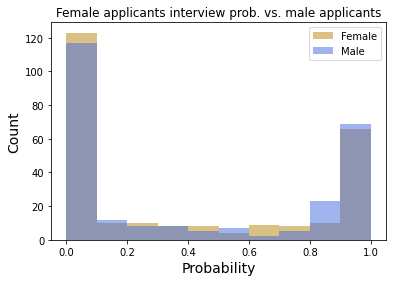

In [59]:
fem_prob, m_prob = get_gender_prob(model, X_test)
plot_hist_prob(fem_prob, m_prob)

From the above, it looks like # females with very low probabilities are more than males and # females in high probabilities are lower than males.

 Compute the difference between interview probability for each sample when
 the gender field is set to female vs. male (0 means no difference, +ve means
 higher probability when the field was set to male, and vice versa) and
 plot the density of this difference.

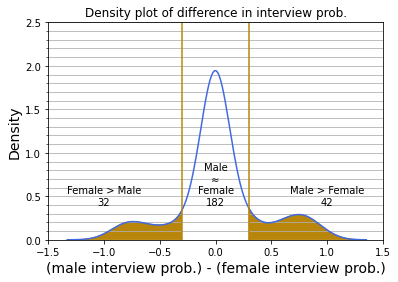

In [60]:
plot_density_prob_diff(fem_prob, m_prob)

# De-biasing the model predictions


In this section we will configure the training-set in order to de-bias the model predictions.

In the literature there are different techniques to handle the bias originating from imbalanced training data  (e.g. the gender gap in some fields as in [Amazon's AI recruiting tool](https://www.reuters.com/article/us-amazon-com-jobs-automation-insight-idUSKCN1MK08G)):

* **Anonymization** to remove the gender markers. However, research have shown that perferct anonymization is a difficult problem, since models can  infer gender not only from name but also from hobbies, university, etc. \\
In this project we did not experiment with anonymization since we are dealing with the preprocessed data and we do not have raw data (e.g. CV text) that includes the gender markers, we only have gender as a binary value.
* **Sampling** to adjust the training-set distribution, by downsampling the overrepresented group or oversampling the underrepresented group.
* **Introducing synthetic data** in the training-set to deter the model from learning a relationship between a protected group (in our case gender)) with the predictions [(Sun, et al. 2019).](https://www.aclweb.org/anthology/P19-1159/). 

In the following subsection, we present our experiments with both sampling and synthetic data techniques.



## Sampling experiments

In this section, we experiment with different ways of balancing the training dataset, through **downsampling** the overrepresented group (e.g. dropping some training examples with male candidates) or **oversampling** the underrespresented group (e.g. using the same training example with female candidates multiple times in every epoch).

The balancing could be done across different dimensions, for example when grouping by some attributes (such as "is interviewed?" and/or "adequate skills ranking score") , each group has an equal number of each gender.

### Downsampling data grouped by "is interviewed?" (y-label)

The y-label is the `ENTRETIEN` in the dataset.

In [61]:
# concatenate the data X,y for easier handling training examples.
data = X_train.copy()
data['ENTRETIEN'] = y_train.copy()

print_gender_stats(data)

# females interviewed 562, # males interviewed 578.
# females not interviewed 514, # males not interviewed 641.
# females interviewed ratio 0.522, # males interviewed ratio 0.474.


#### Creating equally distributed training-set

In [62]:
# copy all females' examples
data_balanced = data[data['FEMME']==1]
# copy equal number of males' examples for interview/not interview variable
fem_interview = [data[(data['FEMME']==1) & (data['ENTRETIEN']==1)],
                 data[(data['FEMME']==1) & (data['ENTRETIEN']==0)]]
m_interview = [data[(data['FEMME']==0) & (data['ENTRETIEN']==1)],
                 data[(data['FEMME']==0) & (data['ENTRETIEN']==0)]]
data_balanced = data_balanced.append(
    [m_interview[0][:fem_interview[0].shape[0]],
     m_interview[1][:fem_interview[1].shape[0]]])

# shuffle the dataset
data_balanced = data_balanced.sample(frac=1).reset_index(drop=True)

# Printing the balanced stats.
print_gender_stats(data_balanced)

# females interviewed 562, # males interviewed 562.
# females not interviewed 514, # males not interviewed 514.
# females interviewed ratio 0.522, # males interviewed ratio 0.522.


In [63]:
# Removing the y-label from model input.
y_train_balanced = data_balanced['ENTRETIEN']
X_train_balanced = data_balanced.loc[:, data_balanced.columns != 'ENTRETIEN']

#### Train with balanced data

In [64]:
model_balanced = build_train_model(X_train_balanced,y_train_balanced)
evaluate_model(model_balanced,X_test,y_test)

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Accuracy on test-set: 95.31%
Confusion matrix:
 [[125  11]
 [  1 119]]


#### Testing bias in the updated model

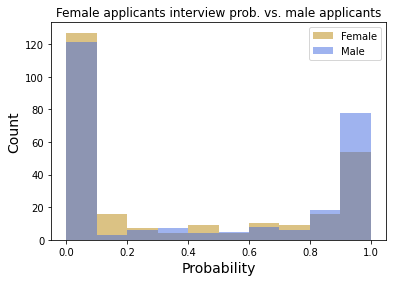

In [65]:
# Returns the probability of being interviewed for all test examples,
# when the gender field is set to female vs. male.
fem_prob, m_prob = get_gender_prob(model_balanced, X_test)

# Plots histogram of probability of being interviewed for both genders.
plot_hist_prob(fem_prob, m_prob)

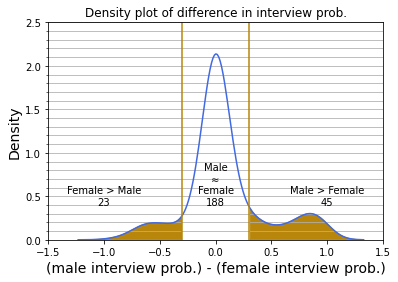

In [66]:
# For each example, compute ((male interview prob.) - (female interview prob.))
# and plot this difference.
plot_density_prob_diff(fem_prob, m_prob)

### Oversampling data grouped by "is interviewed?" (y-label)

The y-label is the `ENTRETIEN` in the dataset.

In [67]:
# concatenate the data X,y for easier handling training examples.
data = X_train.copy()
data['ENTRETIEN'] = y_train.copy()

#print_gender_stats(data_balanced)

#### Creating equally distributed training-set


In [68]:
# copy all  examples
data_balanced = data.copy()

fem_interview = [data[(data['FEMME']==1) & (data['ENTRETIEN']==1)],
                 data[(data['FEMME']==1) & (data['ENTRETIEN']==0)]]
m_interview = [data[(data['FEMME']==0) & (data['ENTRETIEN']==1)],
                 data[(data['FEMME']==0) & (data['ENTRETIEN']==0)]]

# add examples to match the number of female applicant with males 
# for interview/not interview variable
data_balanced = data_balanced.append(
    [fem_interview[0][:m_interview[0].shape[0]-fem_interview[0].shape[0]],
     fem_interview[1][:m_interview[1].shape[0]-fem_interview[1].shape[0]]])

# shuffle the dataset
data_balanced = data_balanced.sample(frac=1).reset_index(drop=True)

# Printing the balanced stats.
print_gender_stats(data_balanced)

# females interviewed 578, # males interviewed 578.
# females not interviewed 641, # males not interviewed 641.
# females interviewed ratio 0.474, # males interviewed ratio 0.474.


In [69]:
# Removing the y-label from model input.
y_train_balanced = data_balanced['ENTRETIEN']
X_train_balanced = data_balanced.loc[:, data_balanced.columns != 'ENTRETIEN']

#### Train with balanced data

In [70]:
model_balanced = build_train_model(X_train_balanced,y_train_balanced)
evaluate_model(model_balanced,X_test,y_test)

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Accuracy on test-set: 95.31%
Confusion matrix:
 [[125  11]
 [  1 119]]


#### Testing bias in the updated model

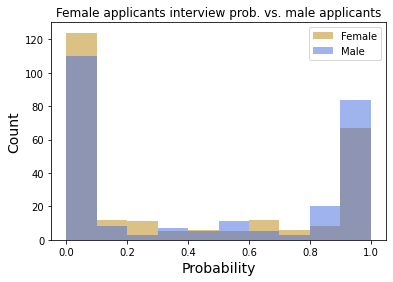

In [71]:
# Returns the probability of being interviewed for all test examples,
# when the gender field is set to female vs. male.
fem_prob, m_prob = get_gender_prob(model_balanced, X_test)

# Plots histogram of probability of being interviewed for both genders.
plot_hist_prob(fem_prob, m_prob)

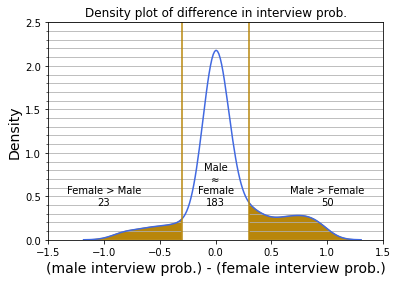

In [72]:
# For each example, compute ((male interview prob.) - (female interview prob.))
# and plot this difference.
plot_density_prob_diff(fem_prob, m_prob)

### Downsampling data grouped by "adequate skills score"

The adequate skills score is the `CV_qualif` column in the dataset.

In [73]:
# concatenate the data X,y for easier handling training examples.
data = X_train.copy()
data['ENTRETIEN'] = y_train.copy()

print_qualification_stats(data)

# females with qualif=1: 545, # males qualif=1: 580.
# females with qualif=0.5: 193, # males qualif=0.5: 272.
# females with qualif=0: 338, # males qualif=0: 367.



#### Creating equally distributed training-set

In [74]:
# copy all females' examples
data_balanced = data[data['FEMME']==1]

# copy equal number of males' examples for each qualification level
fem_qualif = [data[(data['FEMME']==1) & (data['CV_qualif']==1)],
                 data[(data['FEMME']==1) & (data['CV_qualif']>0) & (data['CV_qualif']<1)],
            data[(data['FEMME']==1) & (data['CV_qualif']==0)]]
m_qualif = [data[(data['FEMME']==0) & (data['CV_qualif']==1)],
                 data[(data['FEMME']==0) & (data['CV_qualif']>0) & (data['CV_qualif']<1)],
          data[(data['FEMME']==0) & (data['CV_qualif']==0)]]
data_balanced = data_balanced.append(
    [m_qualif[0][:fem_qualif[0].shape[0]],
     m_qualif[1][:fem_qualif[1].shape[0]],
     m_qualif[2][:fem_qualif[2].shape[0]]])


# shuffle the dataset
data_balanced = data_balanced.sample(frac=1).reset_index(drop=True)

# Printing the balanced stats.
print_qualification_stats(data_balanced)

# females with qualif=1: 545, # males qualif=1: 545.
# females with qualif=0.5: 193, # males qualif=0.5: 193.
# females with qualif=0: 338, # males qualif=0: 338.



In [75]:
# Removing the y-label from model input.
y_train_balanced = data_balanced['ENTRETIEN']
X_train_balanced = data_balanced.loc[:, data_balanced.columns != 'ENTRETIEN']

#### Train with balanced data

In [76]:
model_balanced = build_train_model(X_train_balanced,y_train_balanced)
evaluate_model(model_balanced,X_test,y_test)

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Accuracy on test-set: 94.53%
Confusion matrix:
 [[127   9]
 [  5 115]]


#### Testing bias in the updated model

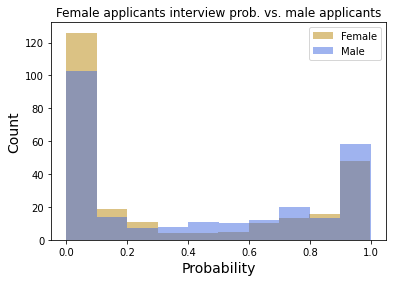

In [77]:
# Returns the probability of being interviewed for all test examples,
# when the gender field is set to female vs. male.
fem_prob, m_prob = get_gender_prob(model_balanced, X_test)

# Plots histogram of probability of being interviewed for both genders.
plot_hist_prob(fem_prob, m_prob)

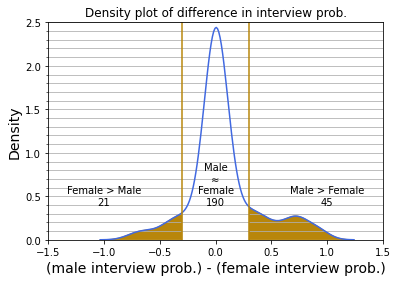

In [78]:
# For each example, compute ((male interview prob.) - (female interview prob.))
# and plot this difference.
plot_density_prob_diff(fem_prob, m_prob)

### Oversampling  data grouped by "adequate skills score"

The adequate skills score is the `CV_qualif` column in the dataset.

In [79]:
# concatenate the data X,y for easier handling training examples.
data = X_train.copy()
data['ENTRETIEN'] = y_train.copy()

#print_gender_stats(data_balanced)

#### Creating equally distributed training-set


In [80]:
# copy all  examples
data_balanced = data.copy()

fem_qualif = [data[(data['FEMME']==1) & (data['CV_qualif']==1)],
                 data[(data['FEMME']==1) & (data['CV_qualif']>0) & (data['CV_qualif']<1)],
            data[(data['FEMME']==1) & (data['CV_qualif']==0)]]
m_qualif = [data[(data['FEMME']==0) & (data['CV_qualif']==1)],
                 data[(data['FEMME']==0) & (data['CV_qualif']>0) & (data['CV_qualif']<1)],
          data[(data['FEMME']==0) & (data['CV_qualif']==0)]]

# add examples to match the number of female applicant with males 
# for each qualification level to match male examples
data_balanced = data_balanced.append(
    [fem_qualif[0][:m_qualif[0].shape[0]-fem_qualif[0].shape[0]],
     fem_qualif[1][:m_qualif[1].shape[0]-fem_qualif[1].shape[0]],
     fem_qualif[2][:m_qualif[2].shape[0]-fem_qualif[2].shape[0]]])


# shuffle the dataset
data_balanced = data_balanced.sample(frac=1).reset_index(drop=True)

# Printing the balanced stats.
print_qualification_stats(data_balanced)

# females with qualif=1: 580, # males qualif=1: 580.
# females with qualif=0.5: 272, # males qualif=0.5: 272.
# females with qualif=0: 367, # males qualif=0: 367.



In [81]:
# Removing the y-label from model input.
y_train_balanced = data_balanced['ENTRETIEN']
X_train_balanced = data_balanced.loc[:, data_balanced.columns != 'ENTRETIEN']

#### Train with balanced data

In [82]:
model_balanced = build_train_model(X_train_balanced,y_train_balanced)
evaluate_model(model_balanced,X_test,y_test)

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Accuracy on test-set: 95.70%
Confusion matrix:
 [[126  10]
 [  1 119]]


#### Testing bias in the updated model

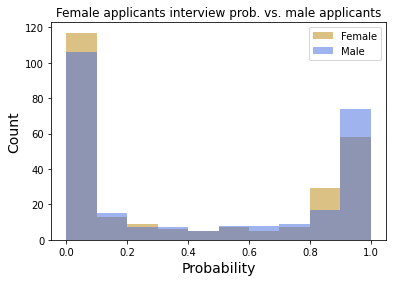

In [83]:
# Returns the probability of being interviewed for all test examples,
# when the gender field is set to female vs. male.
fem_prob, m_prob = get_gender_prob(model_balanced, X_test)

# Plots histogram of probability of being interviewed for both genders.
plot_hist_prob(fem_prob, m_prob)

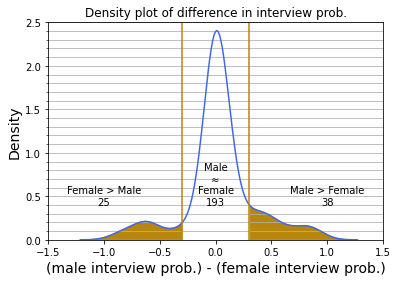

In [84]:
# For each example, compute ((male interview prob.) - (female interview prob.))
# and plot this difference.
plot_density_prob_diff(fem_prob, m_prob)

## Synthetic data experiments

In this section, we experiment with training with synthetic examples. To force the model to not correlate the gender with interview decision (y-label), we will add examples to the dataset with gender variable set once to male and once as female. 

### Fully synthetic dataset
Training-set with all the examples set once as male and another as female.



In [85]:
# concatenate the data X,y for easier handling training examples.
data = X_train.copy()
data['ENTRETIEN'] = y_train.copy()

# copy all examples and set gender to female
data_balanced = data.assign(FEMME=1)
# append all examples again but with gender as male
data_balanced = data_balanced.append(data.assign(FEMME=0))

# shuffle data
data_balanced = data_balanced.sample(frac=1).reset_index(drop=True)
print_gender_stats(data_balanced)

# females interviewed 1140, # males interviewed 1140.
# females not interviewed 1155, # males not interviewed 1155.
# females interviewed ratio 0.497, # males interviewed ratio 0.497.


#### Creating equally distributed training-set

In [86]:
# Removing the y-label from model input.
y_train_balanced = data_balanced['ENTRETIEN']
X_train_balanced = data_balanced.loc[:, data_balanced.columns != 'ENTRETIEN']

#### Train with balanced data

In [87]:
model_balanced = build_train_model(X_train_balanced,y_train_balanced)
evaluate_model(model_balanced,X_test,y_test)

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Accuracy on test-set: 95.31%
Confusion matrix:
 [[124  12]
 [  0 120]]


#### Testing bias in the updated model

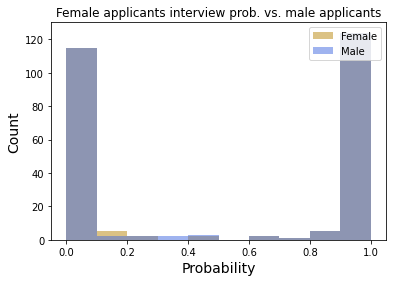

In [88]:
# Returns the probability of being interviewed for all test examples,
# when the gender field is set to female vs. male.
fem_prob, m_prob = get_gender_prob(model_balanced, X_test)

# Plots histogram of probability of being interviewed for both genders.
plot_hist_prob(fem_prob, m_prob)

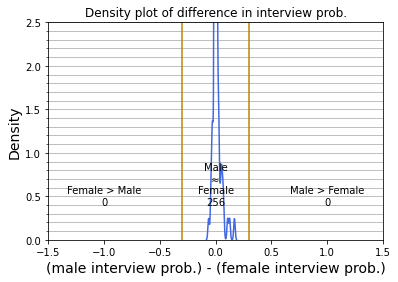

In [89]:
# For each example, compute ((male interview prob.) - (female interview prob.))
# and plot this difference.
plot_density_prob_diff(fem_prob, m_prob)

### Partially synthetic dataset
Training-set with added subset of examples that are set to the opposite gender.



In [90]:
# number of synthetic samples to add, now set to 0.2 of the training-set size
N_SYNTH = int(X_train.shape[0]*0.2)

# concatenate the data X,y for easier handling training examples.
data = X_train.copy()
data['ENTRETIEN'] = y_train.copy()

# copy the training-set examples
data_balanced = data.copy()

# add N_SYNTH synthetic examples  with the opposite gender
synth_data = data_balanced.iloc[:N_SYNTH,:].copy()
synth_data = synth_data.assign(FEMME=1-synth_data['FEMME'])
data_balanced = data_balanced.append(synth_data)

# shuffle data
data_balanced = data_balanced.sample(frac=1).reset_index(drop=True)


#### Creating equally distributed training-set

In [91]:
# Removing the y-label from model input.
y_train_balanced = data_balanced['ENTRETIEN']
X_train_balanced = data_balanced.loc[:, data_balanced.columns != 'ENTRETIEN']

#### Train with balanced data

In [92]:
model_balanced = build_train_model(X_train_balanced,y_train_balanced)
evaluate_model(model_balanced,X_test,y_test)

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Accuracy on test-set: 95.31%
Confusion matrix:
 [[126  10]
 [  2 118]]


#### Testing bias in the updated model

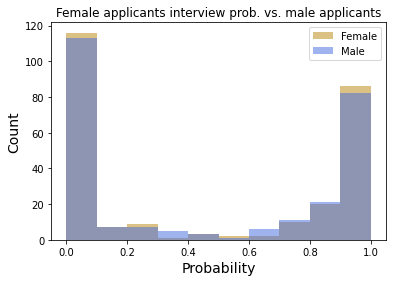

In [93]:
# Returns the probability of being interviewed for all test examples,
# when the gender field is set to female vs. male.
fem_prob, m_prob = get_gender_prob(model_balanced, X_test)

# Plots histogram of probability of being interviewed for both genders.
plot_hist_prob(fem_prob, m_prob)

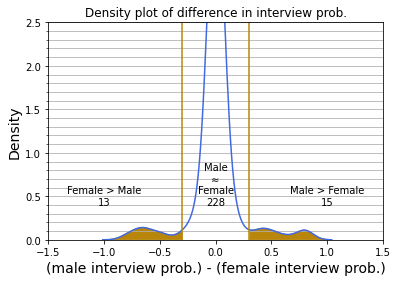

In [94]:
# For each example, compute ((male interview prob.) - (female interview prob.))
# and plot this difference.
plot_density_prob_diff(fem_prob, m_prob)

# Conclusion

The table below shows the different de-biasing experiments' results in terms of model accuracy and the number of examples where a difference in probability was observed from the modified test-set. We can see that the sampling experiments grouped by “interview” were not as effective in decreasing the bias as the ones grouped by “adequate skills score”. We observed no significant difference between downsampling and oversampling when grouping by the same variable. Synthetic data experiments showed better de-biasing results that vary with the percentage of synthetic data introduced, and that the experiment with 20% synthetic data still vastly outperforms any of the sampling techniques.
In terms of model performance, all de-biasing techniques decreased the accuracy by ~1-2%.



|                          | Accuracy | Female > Male | Female ≈ Male | Male > Female |
| ------------- |:-------------:|:-------------:| :-----:|:-----: |
| Original                 | 96.48% | 32 | 182 | 42 | 
| Downsampling (interview) | 95.31% | 23 | 188 | 45 |
| Oversampling (interview) | 95.31% | 23 | 183 | 50 |
| Downsampling( skills)    | 94.53% | 21 | 190 | 45 |
| Oversampling (skills)| 95.70% | 25 | 193 | 38 |
| Synthetic (100%)         | 95.31% | 0  | 256 |  0 |
| Synthetic (20%)          | 95.31% | 13 | 228 | 15 |

Using anonymization for de-biasing requires not only adjusting the training-set, but also it must be applied in production to all inputs given to the model. On the other hand, sampling techniques and adding synthetic data are only done to the training-set, and do not require any changes in production. 

While sampling is easily automated, it is not guaranteed to decrease the bias.  Adding synthetic data proved to significantly decrease the bias. However, it could be expensive to generate high quality synthetic data (e.g. hiring human annotators, or developing a system to recognize gender markers and modify them).




# Bibliography

* Behaghel, L., Crépon, B., & Le Barbanchon, T. (2015). Unintended Effects of Anonymous Résumés. American Economic Journal: Applied Economics, 7(3), 1-27.


* Using random forest to learn imbalanced data (2004). Available online at https://scholar.google.com/citations?user=5qujoo4aaaaj&hl=en&oi=sra.


* Sun, W. (2019). Mitigating Gender Bias in Natural Language Processing: Literature Review. In Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics (pp. 1630–1640). Association for Computational Linguistics.